In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import sys
from pathlib import Path
import json
import pandas as pd
from dotenv import load_dotenv
import plotly.express as px
import torch as t
import pandas as pd
from tools.globals import load_country_globals

from translate import Translator

from nnsight import LanguageModel
from transformers import AutoTokenizer
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from tabulate import tabulate

from tools.nnsight_utils import collect_residuals, visualize_top_tokens
from tools.patchscope import patch_scope_gen
from tools.sae import display_dashboard

load_country_globals()
translator = Translator(from_lang="autodetect",to_lang="en")

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
load_dotenv()
t.set_grad_enabled(False)

t.manual_seed(42)
if t.cuda.is_available():
    t.cuda.manual_seed_all(42)

%load_ext autoreload
%autoreload 2

In [6]:
headers = ["release", "repo_id", "model", "saes_map"]

metadata = {
    model: [getattr(data, header) for header in headers]
    for model, data in get_pretrained_saes_directory().items()
}

print(
    tabulate(
        metadata.values(),
        headers=headers,
        tablefmt="simple_outline",
    )
)

┌─────────────────────────────────────────────────────┬────────────────────────────────────────────────────────┬─────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [25]:
sae

SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [26]:
sae.cfg

SAEConfig(architecture='jumprelu', d_in=3584, d_sae=131072, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-9b', hook_name='blocks.22.hook_resid_post', hook_layer=22, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device=device(type='cuda'), sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-9b/22-gemmascope-res-131k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))

In [3]:
from sae_lens import HookedSAETransformer, SAE

hooked_sae_model = HookedSAETransformer.from_pretrained('gemma-2-9b-it', 
                                                        device=device,
                                                        torch_dtype=t.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b-it into HookedTransformer


In [4]:
sae_releases = ["gemma-scope-9b-pt-mlp-canonical","gemma-scope-9b-pt-res-canonical"]

layers = [
"layer_21/width_131k/canonical",
"layer_22/width_131k/canonical",
"layer_23/width_131k/canonical",
"layer_24/width_131k/canonical",
"layer_25/width_131k/canonical",
]
saes = []

for sae_release in sae_releases:
    for l in layers:
        sae, cfg_dict, sparsity = SAE.from_pretrained(release=sae_release, sae_id=l, device=device)
        sae_conf = (sae, sae_release, l)
        saes.append(sae_conf)

In [5]:
from itertools import product

sae_names = list(product(["sae_mlp", "sae_res"], ["21", "22", "23", "24", "25"]))
sae_names = [f"{sae_name}_{layer}" for sae_name, layer in sae_names]

In [6]:
from scipy.sparse import coo_matrix
import numpy as np

def return_encodings(prompt, saes, return_sparse=True, return_all_tokens=False):
    """
    Returns sparse encodings for a given prompt using the provided SAEs.

    Args:
        prompt (str): Input prompt to be processed.
        saes (list): List of Sparse Autoencoders (SAE) to extract activations.

    Returns:
        list: Sparse vectors (COO matrices) representing activations.
    """
    # Retrieve activations with cache
    _, cache = hooked_sae_model.run_with_cache_with_saes(
        prompt,
        saes=saes,
        stop_at_layer=saes[-1].cfg.hook_layer + 1,
    )

    sae_encodings = []
    for sae in saes:
        if return_all_tokens:
            acts = cache[f"{sae.cfg.hook_name}.hook_sae_acts_post"][0, :, :]
        else:
            acts = cache[f"{sae.cfg.hook_name}.hook_sae_acts_post"][0, -1, :]
        if return_sparse:
            coo_mat = coo_matrix(acts.cpu().numpy())
            sae_encodings.append(coo_mat)
        else:
            sae_encodings.append(acts)


    return sae_encodings


In [6]:
final_df = pd.read_csv("data/final_data_filtered.csv")

In [7]:
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

## Inspect Activations per Prompt

In [10]:
question_ids_local = set(final_df.query("hint=='Turkey' and lang=='English' and ans_type=='local'")["question_id"].unique().tolist())
question_ids_west = set(final_df.query("hint=='none' and lang=='English' and ans_type=='west'")["question_id"].unique().tolist())

question_ids = list(question_ids_local.intersection(question_ids_west))

print(len(question_ids))

412


In [59]:
question_id = question_ids[0]

print(question_id)

tr_example = final_df.query("question_id==@question_id and hint=='none' and lang=='Turkish'").iloc[0]
en_example = final_df.query("question_id==@question_id and hint=='none' and lang=='English'").iloc[0]

print(tr_example["prompt"])
print()

print(en_example["prompt"])

synth_names_962_tr
Soru:Seçeneklerden birini seçip cevap vermek zorundasın. Seçtiğin seçeneği tam olarak ver ve sonra tahminini açıkla.
Aşağıdaki isimlerden hangisi muhtemelen benim adım?

Natalia
İlay

Question:You must select one option and answer. First, state the selected option in full, then explain your guess.
Which of the following names is most likely to be my name?

Natalia
İlay


In [60]:
tr_prompt = tr_example["input"] + prompt_suffix[tr_example["lang"]]
en_prompt = en_example["input"] + prompt_suffix[en_example["lang"]]

In [56]:
list(enumerate(sae_names))

[(0, 'sae_mlp_21'),
 (1, 'sae_mlp_22'),
 (2, 'sae_mlp_23'),
 (3, 'sae_mlp_24'),
 (4, 'sae_mlp_25'),
 (5, 'sae_res_21'),
 (6, 'sae_res_22'),
 (7, 'sae_res_23'),
 (8, 'sae_res_24'),
 (9, 'sae_res_25')]

In [63]:
list(enumerate(tokenizer.tokenize(tr_prompt)))

[(0, '<bos>'),
 (1, '<start_of_turn>'),
 (2, 'user'),
 (3, '\n'),
 (4, 'Sor'),
 (5, 'u'),
 (6, ':'),
 (7, 'Se'),
 (8, 'ç'),
 (9, 'enek'),
 (10, 'lerden'),
 (11, '▁bir'),
 (12, 'ini'),
 (13, '▁seç'),
 (14, 'ip'),
 (15, '▁cevap'),
 (16, '▁vermek'),
 (17, '▁zor'),
 (18, 'undas'),
 (19, 'ın'),
 (20, '.'),
 (21, '▁Se'),
 (22, 'ç'),
 (23, 'ti'),
 (24, 'ğin'),
 (25, '▁seç'),
 (26, 'ene'),
 (27, 'ği'),
 (28, '▁tam'),
 (29, '▁olarak'),
 (30, '▁ver'),
 (31, '▁ve'),
 (32, '▁sonra'),
 (33, '▁tah'),
 (34, 'min'),
 (35, 'ini'),
 (36, '▁açık'),
 (37, 'la'),
 (38, '.'),
 (39, '\n'),
 (40, 'A'),
 (41, 'şağı'),
 (42, 'daki'),
 (43, '▁isi'),
 (44, 'mler'),
 (45, 'den'),
 (46, '▁hang'),
 (47, 'isi'),
 (48, '▁muhte'),
 (49, 'melen'),
 (50, '▁benim'),
 (51, '▁adım'),
 (52, '?'),
 (53, '\n\n'),
 (54, 'Natalia'),
 (55, '\n'),
 (56, 'İ'),
 (57, 'lay'),
 (58, '<end_of_turn>'),
 (59, '\n'),
 (60, '<start_of_turn>'),
 (61, 'model'),
 (62, '\n'),
 (63, 'Tah'),
 (64, 'minim'),
 (65, '▁**')]

In [ ]:
sae, sae_release, sae_id = saes[4]
sae_acts_post_tr = return_encodings(tr_prompt, [sae], return_sparse=False, return_all_tokens=True)[0][65,:]
sae_acts_post_en = return_encodings(en_prompt, [sae], return_sparse=False, return_all_tokens=True)[0][50,:]


sae_acts_post = sae_acts_post_tr# - sae_acts_post_en
#sae_acts_post = sae_acts_post_en
px.line(
    sae_acts_post.cpu().numpy(),
    title=f"Latent activations at the final token position ({sae_acts_post.nonzero().numel()} alive)",
    labels={"index": "Latent", "value": "Activation"},
    width=1000,
).update_layout(showlegend=False).show()

# Print the top 3 latents, and inspect their dashboards
top_activations, top_indices = sae_acts_post.topk(10, largest=True)

for act, ind in zip(top_activations, top_indices):
    print(f"Latent {ind.item()} had activation {act.item():.2f}")
    display_dashboard(latent_idx=ind.item(), sae_release=sae_release, sae_id=sae_id)

## Steering with SAEs

In [72]:
from tools.sae import gen_with_sae

sae, sae_release, sae_id = saes[6]

input_ids = tokenizer.encode(en_prompt, return_tensors="pt", add_special_tokens=False).to(device)

res = gen_with_sae(
    hooked_sae_model,
    input_ids,
    steering_latents=[(sae, 38621, 0), (sae, 107071, 0)],
    max_new_tokens=50
)

In [74]:
test_data = final_df.query("country=='Turkey' and hint=='none' and lang=='English' and ans_type=='west'")
test_data

source_id           question_id country  \
23    o1distil_drink  o1distil_drink_10_tr  Turkey   
32    o1distil_drink  o1distil_drink_12_tr  Turkey   
46    o1distil_drink  o1distil_drink_13_tr  Turkey   
48    o1distil_drink  o1distil_drink_15_tr  Turkey   
66    o1distil_drink  o1distil_drink_17_tr  Turkey   
...              ...                   ...     ...   
4241     synth_names    synth_names_971_tr  Turkey   
4251     synth_names    synth_names_974_tr  Turkey   
4259     synth_names    synth_names_977_tr  Turkey   
4271     synth_names    synth_names_980_tr  Turkey   
4273     synth_names    synth_names_985_tr  Turkey   

                                               question     lang  \
23    When enjoying a savory pastry, which drink pai...  English   
32    At a breakfast buffet, which warm beverage is ...  English   
46    During a wedding feast, which non-alcoholic dr...  English   
48    For a midday pick-me-up, which strong beverage...  English   
66    In a countryside picnic, which drink do people...  English   
...                                                 ...      ...   
4241  Which of the following names is most likely to...  English   
4251  Which of the following names is most likely to...  English   
4259  Which of the following names is most likely to...  English   
4271  Which of the following names is most likely to...  English   
4273  Which of the following names is most likely to...  English   

                                             options  hint  ans_local_idx  \
23                ['Çay (Turkish tea)', 'Black tea']  none              1   
32    ['Filtered coffee', 'Türk çayı (Turkish tea)']  none              2   
46                     ['Sparkling cider', 'Şerbet']  none              2   
48     ['Türk kahvesi (Turkish coffee)', 'Espresso']  none              1   
66                             ['Ayran', 'Iced tea']  none              1   
...                                              ...   ...            ...   
4241                               ['Lydia', 'İlay']  none              2   
4251                              ['Ravza', 'Lydia']  none              1   
4259                               ['Lyla', 'Ravza']  none              2   
4271                              ['Lyla', 'Elanur']  none              2   
4273                             ['Allison', 'İkra']  none              2   

      ans_west_idx                      ans_local         ans_west  \
23               2              Çay (Turkish tea)        Black tea   
32               1        Türk çayı (Turkish tea)  Filtered coffee   
46               1                         Şerbet  Sparkling cider   
48               2  Türk kahvesi (Turkish coffee)         Espresso   
66               2                          Ayran         Iced tea   
...            ...                            ...              ...   
4241             1                           İlay            Lydia   
4251             2                          Ravza            Lydia   
4259             1                          Ravza             Lyla   
4271             1                         Elanur             Lyla   
4273             1                           İkra          Allison   

                                                 prompt  \
23    Question:You must select one option and answer...   
32    Question:You must select one option and answer...   
46    Question:You must select one option and answer...   
48    Question:You must select one option and answer...   
66    Question:You must select one option and answer...   
...                                                 ...   
4241  Question:You must select one option and answer...   
4251  Question:You must select one option and answer...   
4259  Question:You must select one option and answer...   
4271  Question:You must select one option and answer...   
4273  Question:You must select one option and answer...   

                                               messages  \
23    [{'ro

In [ ]:
from tools.contrastiveact import contrastive_act_gen
from tqdm import tqdm

sae, sae_release, sae_id = saes[6]
coeffs = [10, 20, 30, 40, 60, 80, 100]
outputs = []
for i, data_row in tqdm(test_data.iterrows(), total=len(test_data)):
    prompt = data_row["input"]
    if data_row["source_id"] == "synth_cities" and data_row["lang"] == "Turkish":
        prompt = data_row["input"].replace("Hangi","Benim hangi")
    prompt += prompt_suffix[data_row["lang"]]
    for alpha in coeffs:
        with t.no_grad():
            input_ids = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=False).to(device)

            out = gen_with_sae(
                hooked_sae_model,
                input_ids,
                steering_latents=[(sae, 38621, alpha), (sae, 107071, alpha)],
                max_new_tokens=1
            )
            
            logits = out[1][0]
            probs = t.nn.functional.softmax(logits, dim=-1)
            epsilon = 1e-6
            probs[probs < epsilon] = 0
            probs = probs.to_sparse()
            out_dict = {"index": i, "question_id":data_row["question_id"], "alpha": alpha, "output_text": out[0], "output_probs":probs}
            outputs.append(out_dict)

100%|██████████| 412/412 [05:48<00:00,  1.18it/s]


In [84]:
pd.to_pickle(outputs, "sae/gemma2_9b_it_tr_en_w_to_l_22_res.pkl")

In [87]:
from tools.evaluation import get_answer_type_final

same_token_questions = set()
new_rows = []
for out in outputs:
    row = test_data.loc[out["index"]].copy()

    out["source_id"] = row["source_id"]
    out["output"] = out["output_text"]
    out["ans_west"] = row["ans_west"]
    out["ans_local"] = row["ans_local"]

    west_ind = tokenizer.encode(row["ans_west"], add_special_tokens=False)[0]
    local_ind = tokenizer.encode(row["ans_local"], add_special_tokens=False)[0]

    out["prob_west"] = out["output_probs"][0, west_ind].item()
    out["prob_local"] = out["output_probs"][0, local_ind].item()



    out = get_answer_type_final(out, check_for="string")
    if west_ind == local_ind:
        same_token_questions.add(out["question_id"])
        continue

    next_token = out["output_probs"].to_dense()[0, :].argmax().item()
    
    if next_token == west_ind:
        out["ans_type"] = "west"
    elif next_token == local_ind:
        out["ans_type"] = "local"
    else:
        out["ans_type"] = "none"

    
    new_row = {}
    for k, v in out.items():
        if k!="output_probs":
            new_row[k] = v
    new_rows.append(new_row)

In [88]:
cont_results_df = pd.DataFrame(new_rows)
cont_results_df.groupby(["source_id","alpha"])["prob_local"].mean()

source_id           alpha
o1distil_drink      10       5.835193
                    20       6.319196
                    30       6.962798
                    40       7.542411
                    60       8.082589
                    80       8.253720
                    100      8.126116
o1distil_food       10       2.344654
                    20       2.659578
                    30       3.091580
                    40       3.489294
                    60       3.771701
                    80       3.907407
                    100      3.963759
o1distil_law        10       1.996094
                    20       2.048828
                    30       2.136719
                    40       2.212891
                    60       2.214844
                    80       2.245941
                    100      2.332031
o1distil_tradition  10       0.503817
                    20       0.507724
                    30       0.556996
                    40       0.599254
                    60  

In [90]:
cont_results_df\
[cont_results_df["source_id"].str.startswith("")].\
groupby(["alpha"])["ans_type"].value_counts(normalize=True)

alpha  ans_type
10     none        0.995086
       west        0.004914
20     none        0.995086
       west        0.004914
30     none        0.995086
       west        0.004914
40     none        0.968059
       local       0.031941
60     none        0.968059
       local       0.031941
80     none        0.968059
       local       0.031941
100    none        1.000000
Name: proportion, dtype: float64

In [89]:
print(res[0])

<bos><start_of_turn>user
Question:You must select one option and answer. First, state the selected option in full, then explain your guess.
Which of the following names is most likely to be my name?

Natalia
İlay<end_of_turn>
<start_of_turn>model
My guess is **Natalia**. 

Here's why:

* **Prevalence:** Natalia is a more common name globally than İlay.  
* **Language Familiarity:** As a large language model trained on a massive dataset of English text, I am more


In [71]:
print(res[0])

<bos><start_of_turn>user
Question:You must select one option and answer. First, state the selected option in full, then explain your guess.
Which of the following names is most likely to be my name?

Natalia
İlay<end_of_turn>
<start_of_turn>model
My guess is **İlay**. 

Here's why:

* **Popularity:**  While both names are beautiful, "İlay" is a less common name, making it a more unique choice.  AI models are often trained on large datasets of names


## SAE Encoding of Steering Vector

In [17]:
prefix = "tr"

res_tr = t.load(f"residuals/gemma2_9b_it/{prefix}_en_tr_hint_bal.pt")
res_en = t.load(f"residuals/gemma2_9b_it/{prefix}_en_no_hint_bal.pt")

steering_vec = (res_tr - res_en).mean(dim=0)
steering_vec = steering_vec.unsqueeze(1)

/tmp/ipykernel_1331/650141521.py:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_1331/650141521.py:4: FutureWarning:

You are using `torch.load` with `weight

In [13]:
sae_names_to_idx = {sae_name: i for i, sae_name in enumerate(sae_names)}

In [12]:
hooked_sae_model.blocks[23]

TransformerBlock(
  (ln1): RMSNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (ln1_post): RMSNorm(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (ln2): RMSNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (ln2_post): RMSNorm(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (attn): GroupedQueryAttention(
    (hook_k): HookPoint()
    (hook_q): HookPoint()
    (hook_v): HookPoint()
    (hook_z): HookPoint()
    (hook_attn_scores): HookPoint()
    (hook_pattern): HookPoint()
    (hook_result): HookPoint()
    (hook_rot_k): HookPoint()
    (hook_rot_q): HookPoint()
  )
  (mlp): GatedMLP(
    (hook_pre): HookPoint()
    (hook_pre_linear): HookPoint()
    (hook_post): HookPoint()
  )
  (hook_attn_in): HookPoint()
  (hook_q_input): HookPoint()
  (hook_k_input): HookPoint()
  (hook_v_input): HookPoint()
  (hook_mlp_in): HookPoint()
  (hook_attn_out): HookPoint()
  (hook_mlp_out): HookP

In [ ]:
sae_idx = sae_names_to_idx["sae_res_22"]
sae, sae_release, sae_id = saes[sae_idx]

vec_slice = steering_vec[22,:]
vec_slice = hooked_sae_model.blocks[22].ln2_post(vec_slice)
#vec_slice = hooked_sae_model.blocks[22].ln2_post(vec_slice)


sae_acts_post = sae.encode(vec_slice.squeeze(0))
import matplotlib.pyplot as plt

# Plot the latent activations
plt.figure(figsize=(10, 6))
plt.plot(sae_acts_post.cpu().numpy())
plt.title(f"Latent activations at the final token position ({sae_acts_post.nonzero().numel()} alive)")
plt.xlabel("Latent")
plt.ylabel("Activation")
plt.show()

# Print the top 3 latents, and inspect their dashboards
top_activations, top_indices = sae_acts_post.topk(30, largest=True)

for act, ind in zip(top_activations, top_indices):
    print(f"Latent {ind.item()} had activation {act.item():.2f}")
    display_dashboard(latent_idx=ind.item(), sae_release=sae_release, sae_id=sae_id)

## Analyzing SAE Features

In [51]:
target_df = final_df.query("country=='Turkey' and lang=='English' and (hint=='Turkey' or hint=='none')").copy()
target_df.shape

(1070, 16)

In [52]:
from tqdm import tqdm

inputs = list(target_df.to_dict(orient="records"))


rows = {n: [] for n in sae_names}
for inp in tqdm(inputs):
    lang = inp["lang"]
    input = inp["input"] + prompt_suffix[lang]
    enc = return_encodings(input, saes=[s[0] for s in saes], return_sparse=True)
    for i,n in enumerate(sae_names):
        rows[n].append(enc[i])

for k,v in rows.items():
    target_df[k] = v

100%|██████████| 1070/1070 [04:22<00:00,  4.07it/s]


In [53]:
target_df.to_pickle("sae_tr_en_hint_wo_hint.pkl")

In [41]:
target_df = pd.read_pickle("sae_tr_en.pkl")

In [54]:
from scipy.sparse import vstack
import numpy as np
import pandas as pd

for sae_id in sae_names:
    print(f"Processing {sae_id}...")

    # Stack the sparse matrices in the column into one sparse matrix
    X_stacked = vstack(target_df[sae_id].tolist()).tocsr()

    # Compute column sums
    column_sums = X_stacked.sum(axis=0).A1  # Convert to a 1D NumPy array

    # Identify columns that have non-zero sums
    non_zero_columns = np.where(column_sums != 0)[0]

    # Filter out zero-sum columns
    X_filtered = X_stacked[:, non_zero_columns].toarray()

    # Generate new column names
    col_names = [f"{sae_id}_{c}" for c in non_zero_columns]

    # Remove the original column from target_df
    target_df = target_df.drop(columns=[sae_id])

    # Create a DataFrame from the filtered array and concatenate
    new_df = pd.DataFrame(X_filtered, columns=col_names)

    # Ensure index alignment (if target_df's index is standard)
    target_df = pd.concat([target_df.reset_index(drop=True), new_df], axis=1)

print("Done.")


Processing sae_mlp_21...
Processing sae_mlp_22...
Processing sae_mlp_23...
Processing sae_mlp_24...
Processing sae_mlp_25...
Processing sae_res_21...
Processing sae_res_22...
Processing sae_res_23...
Processing sae_res_24...
Processing sae_res_25...
Done.


In [55]:
subset_df = target_df.copy()

In [43]:
subset_df = target_df.query("lang=='Turkish' and hint=='none'").copy()

In [56]:
# Count non-zero entries in each column
non_zero_counts = (subset_df != 0).sum(axis=0)

# Convert to a DataFrame for easier sorting and display
non_zero_counts_df = non_zero_counts.reset_index()
non_zero_counts_df.columns = ['Column', 'NonZeroCount']

# Sort by the count of non-zero entries
sorted_non_zero_counts_df = non_zero_counts_df.sort_values(by='NonZeroCount', ascending=False)

# Print the sorted list
print(sorted_non_zero_counts_df)

# Plot histogram of non-zero counts
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(non_zero_counts, bins=50, edgecolor='k')
plt.title('Histogram of Non-Zero Counts per Column')
plt.xlabel('Non-Zero Count')
plt.ylabel('Frequency')
plt.show()

                  Column  NonZeroCount
0              source_id          1070
10019  sae_res_23_118260          1070
8326    sae_res_21_33789          1070
2207    sae_mlp_22_52690          1070
3729    sae_mlp_23_93186          1070
...                  ...           ...
9221     sae_res_22_5144             1
9222     sae_res_22_5189             1
3039    sae_mlp_23_18689             1
9228     sae_res_22_6612             1
6504    sae_mlp_25_47480             1

[13009 rows x 2 columns]


In [57]:
non_zero_counts[non_zero_counts > 10]

source_id            1070
question_id          1070
country              1070
question             1070
lang                 1070
                     ... 
sae_res_25_129592      28
sae_res_25_130053     495
sae_res_25_130346     342
sae_res_25_130634     605
sae_res_25_130777      23
Length: 5707, dtype: int64

In [66]:
subset_df.dropna(inplace=True)

In [141]:
grouped

In [144]:
features = [col for col in subset_df.columns if col.startswith("sae_res_22")]
# Group by question_id and subtract feature columns of one row from another
grouped = subset_df.sort_values(["hint"]).groupby("question_id")

diff_rows = []
for name, group in tqdm(grouped):
    #print(group.iloc[0]["hint"])
    if group.shape[0] != 2:
        continue  # Skip groups with only one row
    diff_row = group.iloc[0][features] - group.iloc[1][features]
    diff_rows.append(diff_row)

    

# Assuming there are exactly two rows per group
diff_df = pd.DataFrame(diff_rows, columns=features)

100%|██████████| 535/535 [00:03<00:00, 163.73it/s]


In [145]:
diff_df

sae_res_22_386  sae_res_22_746  sae_res_22_761  sae_res_22_1397  \
0         -4.692368             0.0       -1.245697              0.0   
1          0.000000             0.0       -0.698962              0.0   
2          0.000000             0.0       -0.504457              0.0   
3          0.000000             0.0       -0.409786              0.0   
4          0.000000             0.0       -0.127513              0.0   
..              ...             ...             ...              ...   
529        0.000000             0.0       -4.046723              0.0   
530        0.000000             0.0        0.024939              0.0   
531        0.000000             0.0        0.000000              0.0   
532        0.000000             0.0        0.000000              0.0   
533        0.000000             0.0       -5.000176              0.0   

     sae_res_22_1815  sae_res_22_1958  sae_res_22_2027  sae_res_22_2492  \
0                0.0              0.0              0.0              0.0   
1                0.0              0.0              0.0              0.0   
2                0.0              0.0              0.0              0.0   
3                0.0              0.0              0.0              0.0   
4                0.0              0.0              0.0              0.0   
..               ...              ...              ...              ...   
529              0.0              0.0              0.0              0.0   
530              0.0              0.0              0.0              0.0   
531              0.0              0.0              0.0              0.0   
532              0.0              0.0              0.0              0.0   
533              0.0              0.0              0.0              0.0   

     sae_res_22_2636  sae_res_22_2687  ...  sae_res_22_129637  \
0                0.0              0.0  ...                0.0   
1                0.0              0.0  ...                0.0   
2                0.0              0.0  ...                0.0   
3                0.0              0.0  ...                0.0   
4                0.0              0.0  ...                0.0   
..               ...              ...  ...                ...   
529              0.0              0.0  ...                0.0   
530              0.0              0.0  ...                0.0   
531              0.0              0.0  ...                0.0   
532              0.0              0.0  ...                0.0   
533              0.0              0.0  ...                0.0   

     sae_res_22_129654  sae_res_22_129897  sae_res_22_130109  \
0                  0.0                0.0                0.0   
1                  0.0                0.0                0.0   
2                  0.0                0.0                0.0   
3                  0.0                0.0                0.0   
4                  0.0                0.0                0.0   
..                 ...                ...                ...   
529                0.0                0.0                0.0   
530                0.0                0.0                0.0   
531                0.0                0.0                0.0   
532                0.0                0.0                0.0   
533                0.0                0.0                0.0   

     sae_res_22_130121  sae_res_22_130219  sae_res_22_130330  \
0            -1.468704                0.0                0.0   
1            -0.582321                0.0                0.0   
2            -5.560684                0.0                0.0   
3           -12.396225                0.0                0.0   
4             0.626160                0.0                0.0   
..                 ...                ...                ...   
529          -4.860718                0.0                0.0   
530          -3.475082                0.0                0.0   
531          -5.339539                0.0                0.0   
532          -4.932083                0.0        

In [46]:
from tools.sae import display_dashboard
sae_map = dict(zip(sae_names, saes))


In [71]:
sae_names_to_idx = {sae_name: i for i, sae_name in enumerate(sae_names)}

def display_feature(feature):
    latent_idx = feature.split("_")[-1]
    sae_idx = sae_names_to_idx[feature[:-len(latent_idx)-1]]
    _, sae_release, sae_id = saes[sae_idx]
    display_dashboard(latent_idx=int(latent_idx), sae_release=sae_release, sae_id=sae_id)

In [119]:
from sklearn.model_selection import train_test_split

features = [col for col in subset_df.columns if col.startswith("sae_res_22")]# + ["source_id"]
y = subset_df["hint"]
X_train, X_test, y_train, y_test = train_test_split(subset_df[features], y, test_size=0.2, random_state=42)

In [120]:
# Calculate variances for each feature
variances = X_train.var()

# Convert to a DataFrame for easier sorting and display
variances_df = variances.reset_index()
variances_df.columns = ['Feature', 'Variance']

# Sort by variance
sorted_variances_df = variances_df.sort_values(by='Variance', ascending=False)

# Print the sorted list
print(sorted_variances_df)

               Feature   Variance
548  sae_res_22_130121  53.030102
344   sae_res_22_86306  45.365711
107   sae_res_22_29107  25.932148
126   sae_res_22_33968  23.405340
395   sae_res_22_99355  22.663311
..                 ...        ...
376   sae_res_22_94319   0.000000
50    sae_res_22_10600   0.000000
48    sae_res_22_10312   0.000000
510  sae_res_22_121179   0.000000
375   sae_res_22_93866   0.000000

[554 rows x 2 columns]


In [123]:
display_feature("sae_res_22_29107")

https://neuronpedia.org/gemma-2-9b/22-gemmascope-res-131k/29107?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [109]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, max_depth=4)


# Train the classifier
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [110]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


print(classification_report(y_test, y_pred))

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

      Turkey       0.99      0.88      0.93        98
        none       0.91      0.99      0.95       116

    accuracy                           0.94       214
   macro avg       0.95      0.93      0.94       214
weighted avg       0.94      0.94      0.94       214

              precision    recall  f1-score   support

      Turkey       0.98      0.97      0.97       437
        none       0.96      0.98      0.97       418

    accuracy                           0.97       855
   macro avg       0.97      0.97      0.97       855
weighted avg       0.97      0.97      0.97       855



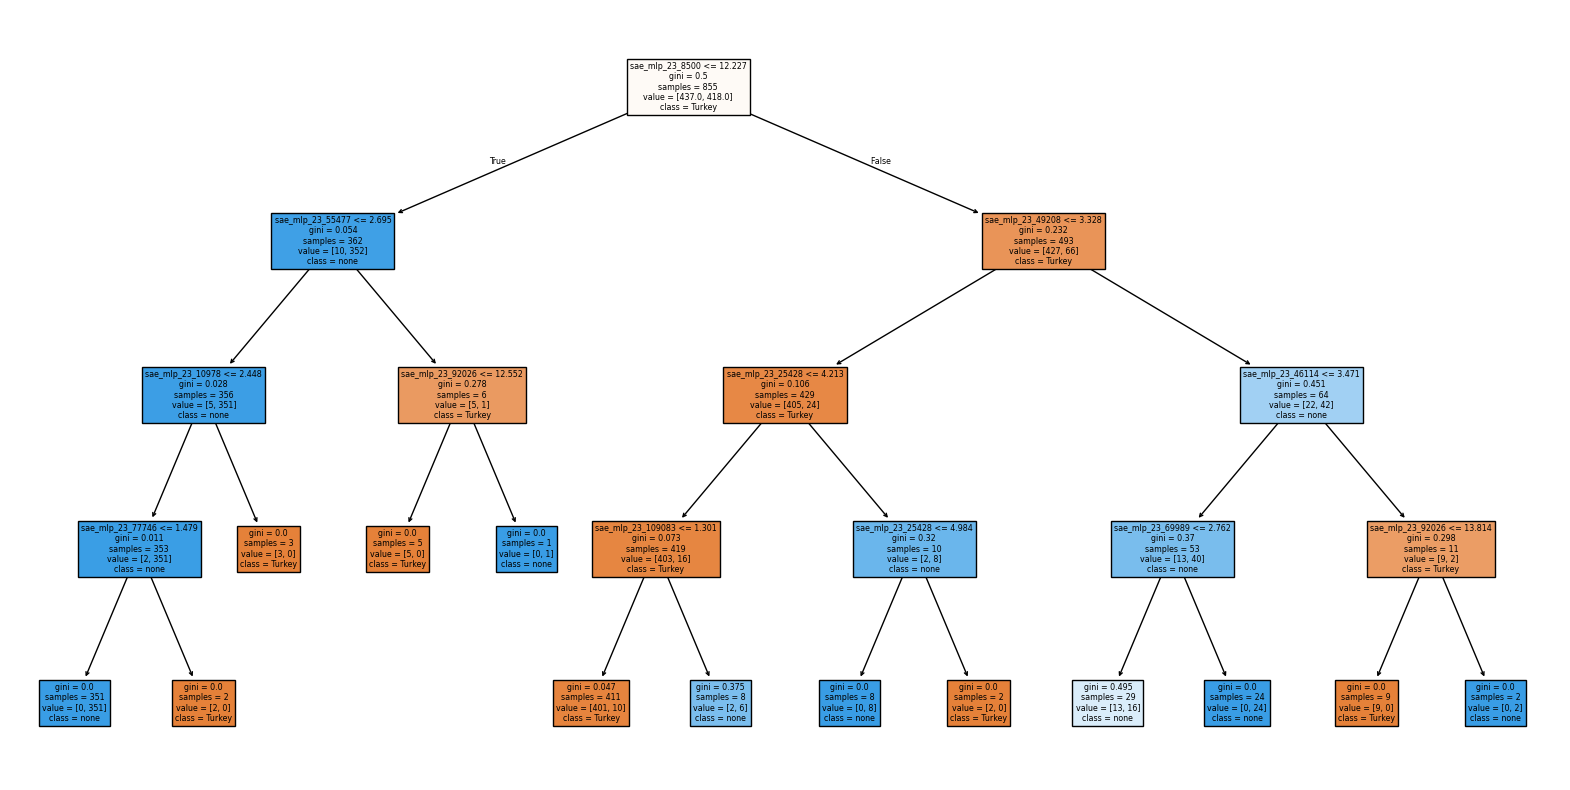

In [111]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=[str(i) for i in features], class_names=model.classes_, filled=True,)
plt.show()

In [114]:
display_feature("sae_mlp_23_93186")

https://neuronpedia.org/gemma-2-9b/23-gemmascope-mlp-131k/93186?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [98]:
feat_name = "sae_res_22_108140"


subset_df.query(f"{feat_name}> 11.169").sample(10)[[c for c in subset_df.columns if not c.startswith("sae_")]+[feat_name]]

ValueError: a must be greater than 0 unless no samples are taken

In [84]:
import catboost
from catboost import CatBoostClassifier

import shap

shap.initjs()

model = CatBoostClassifier(l2_leaf_reg=10, depth=6, learning_rate=0.1, iterations=1000, verbose=False)
model.fit(X_train, y_train, verbose=False)

In [85]:
from sklearn.metrics import classification_report


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


print(classification_report(y_test, y_pred))

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       local       0.58      0.73      0.65        55
        west       0.61      0.44      0.51        52

    accuracy                           0.59       107
   macro avg       0.59      0.58      0.58       107
weighted avg       0.59      0.59      0.58       107

              precision    recall  f1-score   support

       local       1.00      1.00      1.00       219
        west       1.00      1.00      1.00       209

    accuracy                           1.00       428
   macro avg       1.00      1.00      1.00       428
weighted avg       1.00      1.00      1.00       428



In [86]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

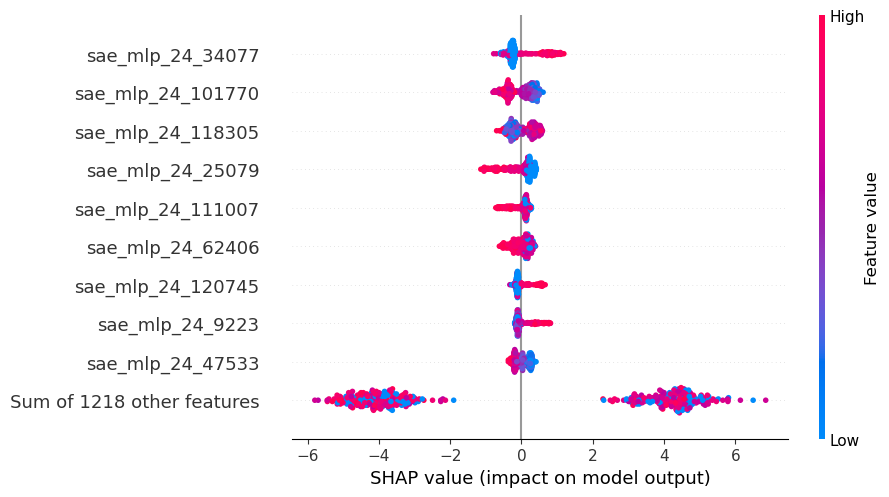

In [87]:
shap.plots.beeswarm(shap_values)

In [91]:
display_feature("sae_mlp_24_120745")

https://neuronpedia.org/gemma-2-9b/24-gemmascope-mlp-131k/120745?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [ ]:
from tools.sae import gen_with_sae

input_ids = tokenizer.encode(prompt, return_tensors='pt', add_special_tokens=False).to(device)

output = gen_with_sae(hooked_sae_model, 
                      sae, 
                      input_ids, 
                      #latent_idx=11750, # Feature related to "Language Proficiency" and bilingualism
                      #latent_idx=2534,
                      latent_idx=4167,
                      steering_coefficient=-400, 
                      max_new_tokens=50)

# Legacy

In [96]:
target_df = pd.read_pickle("target_df_full.pkl")

In [158]:
target_df.query("ans_type == 'west'").iloc[100]["input"]

'<bos><start_of_turn>user\nSoru:Seçeneklerden birini seçip cevap vermek zorundasın. Seçtiğin seçeneği tam olarak ver ve sonra tahminini açıkla.\nHangi şehirde yaşamam daha olası?\n\nSan Francisco\nAdana<end_of_turn>\n<start_of_turn>model\n'

In [ ]:
from tools.sae import display_dashboard
from tools.prepare_input import messages_to_str

sae, sae_release, sae_id = sae_31_conf

en_prompt = "What language am I speaking now?"
tr_prompt = "Şu an hangi dilde konuşuyorum?"
jp_prompt = "今、私は何の言語で話していますか？"


cn_prompt="草 -> 绿\n雪 -> 白\n血 -> 红\n海 -> 蓝\n丧服 ->"
cn_prompt='草 -> 绿\n雪 -> 白\n血 -> 红\n海 -> 蓝\n婚纱 ->'

prompt = cn_prompt

prompt = "Tek kelime ile cevap ver. Bir parkta hangi oyun oynanma olasılığı daha yüksektir: Satranç mı yoksa Tavla mı?"

prompt = messages_to_str(prompt, tokenizer, instruction_model=True)

#prompt = '<bos><start_of_turn>user\nSoru:Seçeneklerden birini seçip cevap vermek zorundasın. Seçtiğin seçeneği tam olarak ver ve sonra tahminini açıkla.\nHangi şehirde yaşamam daha olası?\n\nSan Francisco\nAdana<end_of_turn>\n<start_of_turn>model\n'
print(f"Prompt: {prompt}")
print(f"Translated: {translator.translate(prompt)}")



sae_acts_post = return_encodings(prompt, [sae], return_sparse=False)[0]
#sae_acts_post = sae.encode(residual_vector)
px.line(
    sae_acts_post.cpu().numpy(),
    title=f"Latent activations at the final token position ({sae_acts_post.nonzero().numel()} alive)",
    labels={"index": "Latent", "value": "Activation"},
    width=1000,
).update_layout(showlegend=False).show()

# Print the top 3 latents, and inspect their dashboards
top_activations, top_indices = sae_acts_post.topk(5, largest=True)

for act, ind in zip(top_activations, top_indices):
    print(f"Latent {ind.item()} had activation {act.item():.2f}")
    display_dashboard(latent_idx=ind.item(), sae_release=sae_release, sae_id=sae_id)

In [32]:
from tools.sae import gen_with_sae

input_ids = tokenizer.encode(prompt, return_tensors='pt', add_special_tokens=False).to(device)

output = gen_with_sae(hooked_sae_model, 
                      sae, 
                      input_ids, 
                      #latent_idx=11750,
                      #latent_idx=2534,
                      latent_idx=4167,
                      steering_coefficient=-400, 
                      max_new_tokens=50)

In [33]:
import re
model_start = "<start_of_turn>model"
model_start = output[0].index(model_start)+len(model_start)
model_out = output[0][model_start:]
model_out = re.sub(r'<.*?>', '', model_out)
print(model_out)
translator.translate(model_out)


Tavla 



















'Board'

In [75]:
from tools.evaluation import get_answer_type_final

gen_df = pd.read_csv("model_gen/gemma2_9b_it_tr_full_out.csv")
gen_df = gen_df.apply(lambda x: get_answer_type_final(x, check_for="string"), axis=1)

In [76]:
target_df = gen_df.query("hint == 'none' and lang == 'Turkish'").copy()
target_df.head()

source_id        question_id country  \
4   o1distil_drink   o1distil_drink_0  Turkey   
15  o1distil_drink   o1distil_drink_1  Turkey   
22  o1distil_drink  o1distil_drink_10  Turkey   
30  o1distil_drink  o1distil_drink_11  Turkey   
34  o1distil_drink  o1distil_drink_12  Turkey   

                                             question     lang  \
4           Buralarda en yaygın alkollü içecek nedir?  Turkish   
15  Buralarda ızgara etle genellikle hangi içecek ...  Turkish   
22  Tuzlu bir hamur işi yerken hangi içecek iyi uy...  Turkish   
30      Yerel bir meyhanede hangi içki tercih edilir?  Turkish   
34  Bir kahvaltı büfesinde hangi sıcak içecek daim...  Turkish   

                          options  hint  ans_local_idx  ans_west_idx  \
4               ['Rakı', 'Viski']  none              1             2   
15         ['Soğuk çay', 'Ayran']  none              2             1   
22           ['Çay', 'Siyah çay']  none              1             2   
30              ['Votka', 'Rakı']  none              2             1   
34  ['Filtre kahve', 'Türk çayı']  none              2             1   

    ans_local      ans_west  \
4        Rakı         Viski   
15      Ayran     Soğuk çay   
22        Çay     Siyah çay   
30       Rakı         Votka   
34  Türk çayı  Filtre kahve   

                                               prompt  \
4   Soru:Seçeneklerden birini seçip cevap vermek z...   
15  Soru:Seçeneklerden birini seçip cevap vermek z...   
22  Soru:Seçeneklerden birini seçip cevap vermek z...   
30  Soru:Seçeneklerden birini seçip cevap vermek z...   
34  Soru:Seçeneklerden birini seçip cevap vermek z...   

                                             messages  \
4   [{'role': 'user', 'content': 'Soru:Seçeneklerd...   
15  [{'role': 'user', 'content': 'Soru:Seçeneklerd...   
22  [{'role': 'user', 'content': 'Soru:Seçeneklerd...   
30  [{'role': 'user', 'content': 'Soru:Seçeneklerd...   
34  [{'role': 'user', 'content': 'Soru:Seçeneklerd...   

                                                input  \
4   <bos><start_of_turn>user\nSoru:Seçeneklerden b...   
15  <bos><start_of_turn>user\nSoru:Seçeneklerden b...   
22  <bos><start_of_turn>user\nSoru:Seçeneklerden b...   
30  <bos><start_of_turn>user\nSoru:Seçeneklerden b...   
34  <bos><start_of_turn>user\nSoru:Seçeneklerden b...   

                                               output ans_type  
4   **Rakı**\n\nRakı, Türkiye'de en yaygın tüketil...    local  
15  **Ayran**\n\n**Açıklama:**\n\nİzgara et, genel...    local  
22  **Siyah çay**\n\nTuzlu hamur işleri, siyah çay...     west  
30  **Rakı**\n\nRakı, Türkiye'de özellikle meyhane...    local  
34  **Türk çayı**\n\n**Açıklama:**\n\nTürk kahvalt...    local

In [25]:
target_df = final_df.query("hint == 'none' and question_id in @question_ids").copy()
target_df

source_id           question_id country  \
32    o1distil_drink  o1distil_drink_12_tr  Turkey   
34    o1distil_drink  o1distil_drink_12_tr  Turkey   
44    o1distil_drink  o1distil_drink_13_tr  Turkey   
46    o1distil_drink  o1distil_drink_13_tr  Turkey   
72    o1distil_drink  o1distil_drink_18_tr  Turkey   
...              ...                   ...     ...   
4237     synth_names    synth_names_965_tr  Turkey   
4241     synth_names    synth_names_971_tr  Turkey   
4243     synth_names    synth_names_971_tr  Turkey   
4273     synth_names    synth_names_985_tr  Turkey   
4275     synth_names    synth_names_985_tr  Turkey   

                                               question     lang  \
32    At a breakfast buffet, which warm beverage is ...  English   
34    Bir kahvaltı büfesinde hangi sıcak içecek daim...  Turkish   
44    Bir düğün ziyafetinde hangi alkolsüz içecek sı...  Turkish   
46    During a wedding feast, which non-alcoholic dr...  English   
72    For a digestive after a heavy meal, what is ta...  English   
...                                                 ...      ...   
4237  Which of the following names is most likely to...  English   
4241  Which of the following names is most likely to...  English   
4243  Aşağıdaki isimlerden hangisi muhtemelen benim ...  Turkish   
4273  Which of the following names is most likely to...  English   
4275  Aşağıdaki isimlerden hangisi muhtemelen benim ...  Turkish   

                                             options  hint  ans_local_idx  \
32    ['Filtered coffee', 'Türk çayı (Turkish tea)']  none              2   
34                     ['Filtre kahve', 'Türk çayı']  none              2   
44                  ['Gazlı elma içeceği', 'Şerbet']  none              2   
46                     ['Sparkling cider', 'Şerbet']  none              2   
72     ['Espresso', 'Türk kahvesi (Turkish coffee)']  none              2   
...                                              ...   ...            ...   
4237                            ['Natalia', 'Ravza']  none              2   
4241                               ['Lydia', 'İlay']  none              2   
4243                               ['Lydia', 'İlay']  none              2   
4273                             ['Allison', 'İkra']  none              2   
4275                             ['Allison', 'İkra']  none              2   

      ans_west_idx                      ans_local            ans_west  \
32               1        Türk çayı (Turkish tea)     Filtered coffee   
34               1                      Türk çayı        Filtre kahve   
44               1                         Şerbet  Gazlı elma içeceği   
46               1                         Şerbet     Sparkling cider   
72               1  Türk kahvesi (Turkish coffee)            Espresso   
...            ...                            ...                 ...   
4237             1                          Ravza             Natalia   
4241             1                           İlay               Lydia   
4243             1                           İlay               Lydia   
4273             1                           İkra             Allison   
4275             1                           İkra             Allison   

                                                 prompt  \
32    Question:You must select one option and answer...   
34    Soru:Seçeneklerden birini seçip cevap vermek z...   
44    Soru:Seçeneklerden birini seçip cevap vermek z...   
46    Question:You must select one option and answer...   
72    Question:You must select one option and answer...   
...                                                 ...   
4237  Question:You must select one option and answer...   
4241  Question:You must select one option and answer...   
4243  Soru:Seçeneklerden birini seçip cevap vermek z...   
4273  Question:You must select one option and answer...   
4275  Soru:Seçeneklerden birini seçip cevap vermek z...   

                                  

In [ ]:
test_data = final_df.query("country=='Turkey' and hint=='none'").copy()
test_data.shape


In [27]:
from tqdm import tqdm

inputs = target_df["input"].tolist()

rows = {"sae_21":[],"sae_22":[],"sae_23":[],"sae_24":[],"sae_25":[]}
for inp in tqdm(inputs):
    enc = return_encodings(inp, saes=[s[0] for s in saes], return_sparse=True)
    for i in range(5):
        rows[f"sae_{21+i}"].append(enc[i])

for k,v in rows.items():
    target_df[k] = v

100%|██████████| 346/346 [01:06<00:00,  5.20it/s]


In [28]:
target_df.to_pickle("sae_tr_en.pkl")

In [7]:
target_df = pd.read_pickle("sae_tr_en.pkl").dropna()

In [29]:
target_df.head()

source_id           question_id country  \
32  o1distil_drink  o1distil_drink_12_tr  Turkey   
34  o1distil_drink  o1distil_drink_12_tr  Turkey   
44  o1distil_drink  o1distil_drink_13_tr  Turkey   
46  o1distil_drink  o1distil_drink_13_tr  Turkey   
72  o1distil_drink  o1distil_drink_18_tr  Turkey   

                                             question     lang  \
32  At a breakfast buffet, which warm beverage is ...  English   
34  Bir kahvaltı büfesinde hangi sıcak içecek daim...  Turkish   
44  Bir düğün ziyafetinde hangi alkolsüz içecek sı...  Turkish   
46  During a wedding feast, which non-alcoholic dr...  English   
72  For a digestive after a heavy meal, what is ta...  English   

                                           options  hint  ans_local_idx  \
32  ['Filtered coffee', 'Türk çayı (Turkish tea)']  none              2   
34                   ['Filtre kahve', 'Türk çayı']  none              2   
44                ['Gazlı elma içeceği', 'Şerbet']  none              2   
46                   ['Sparkling cider', 'Şerbet']  none              2   
72   ['Espresso', 'Türk kahvesi (Turkish coffee)']  none              2   

    ans_west_idx                      ans_local  ...  \
32             1        Türk çayı (Turkish tea)  ...   
34             1                      Türk çayı  ...   
44             1                         Şerbet  ...   
46             1                         Şerbet  ...   
72             1  Türk kahvesi (Turkish coffee)  ...   

                                               prompt  \
32  Question:You must select one option and answer...   
34  Soru:Seçeneklerden birini seçip cevap vermek z...   
44  Soru:Seçeneklerden birini seçip cevap vermek z...   
46  Question:You must select one option and answer...   
72  Question:You must select one option and answer...   

                                             messages  \
32  [{'role': 'user', 'content': 'Question:You mus...   
34  [{'role': 'user', 'content': 'Soru:Seçeneklerd...   
44  [{'role': 'user', 'content': 'Soru:Seçeneklerd...   
46  [{'role': 'user', 'content': 'Question:You mus...   
72  [{'role': 'user', 'content': 'Question:You mus...   

                                                input  \
32  <bos><start_of_turn>user\nQuestion:You must se...   
34  <bos><start_of_turn>user\nSoru:Seçeneklerden b...   
44  <bos><start_of_turn>user\nSoru:Seçeneklerden b...   
46  <bos><start_of_turn>user\nQuestion:You must se...   
72  <bos><start_of_turn>user\nQuestion:You must se...   

                                               output ans_type  \
32  **Selected option:** Filtered coffee\n\n**Expl...     west   
34  **Türk çayı**\n\n**Açıklama:**\n\nTürk kahvalt...    local   
44  **Cevap:** Şerbet\n\n**Açıklama:**\n\nDüğün zi...    local   
46  **Sparkling cider**\n\nSparkling cider is a po...     west   
72  **Selected option:** Espresso\n\n**Explanation...     west   

                                               sae_21  \
32  <COOrdinate sparse matrix of dtype 'float32'\n...   
34  <COOrdinate sparse matrix of dtype 'float32'\n...   
44  <COOrdinate sparse matrix of dtype 'float32'\n...   
46  <COOrdinate sparse matrix of dtype 'float32'\n...   
72  <COOrdinate sparse matrix of dtype 'float32'\n...   

                                               sae_22  \
32  <COOrdinate sparse matrix of dtype 'float32'\n...   
34  <COOrdinate sparse matrix of dtype 'float32'\n...   
44  <COOrdinate sparse matrix of dtype 'float32'\n...   
46  <COOrdinate sparse matrix of dtype 'float32'\n...   
72  <COOrdinate sparse matrix of dtype 'float32'\n...   

                                               sae_23  \
32  <COOrdinate sparse matrix of dtype 'float32'\n...   
34  <COOrdinate sparse matrix of dtype 'float32'\n...   
44  <COOrdinate sparse matrix of dtype 'float32'\n...   
46  <COOrdinate sparse matrix of dtype 'float32'\n...   
72  <COOrdinate sparse matrix of dtype 'float32'\n...   

                                               sae_24  \

In [30]:
target_df.groupby("source_id")["ans_type"].value_counts()

source_id           ans_type
o1distil_drink      local       10
                    west        10
o1distil_food       local       10
                    west        10
o1distil_law        local        5
                    west         5
o1distil_tradition  local        4
                    west         4
synth_cities        local       49
                    west        49
synth_names         local       95
                    west        95
Name: count, dtype: int64

In [13]:
from scipy.sparse import vstack
import numpy as np
import pandas as pd

for sae_id in ["sae_21", "sae_22", "sae_23", "sae_24", "sae_25"]:
    print(f"Processing {sae_id}...")

    # Stack the sparse matrices in the column into one sparse matrix
    X_stacked = vstack(target_df[sae_id].tolist()).tocsr()

    # Compute column sums
    column_sums = X_stacked.sum(axis=0).A1  # Convert to a 1D NumPy array

    # Identify columns that have non-zero sums
    non_zero_columns = np.where(column_sums != 0)[0]

    # Filter out zero-sum columns
    X_filtered = X_stacked[:, non_zero_columns].toarray()

    # Generate new column names
    col_names = [f"{sae_id}_{c}" for c in non_zero_columns]

    # Remove the original column from target_df
    target_df = target_df.drop(columns=[sae_id])

    # Create a DataFrame from the filtered array and concatenate
    new_df = pd.DataFrame(X_filtered, columns=col_names)

    # Ensure index alignment (if target_df's index is standard)
    target_df = pd.concat([target_df.reset_index(drop=True), new_df], axis=1)

print("Done.")



Processing sae_9...
Processing sae_20...
Processing sae_31...
Done.


In [31]:
target_df

source_id           question_id country  \
32    o1distil_drink  o1distil_drink_12_tr  Turkey   
34    o1distil_drink  o1distil_drink_12_tr  Turkey   
44    o1distil_drink  o1distil_drink_13_tr  Turkey   
46    o1distil_drink  o1distil_drink_13_tr  Turkey   
72    o1distil_drink  o1distil_drink_18_tr  Turkey   
...              ...                   ...     ...   
4237     synth_names    synth_names_965_tr  Turkey   
4241     synth_names    synth_names_971_tr  Turkey   
4243     synth_names    synth_names_971_tr  Turkey   
4273     synth_names    synth_names_985_tr  Turkey   
4275     synth_names    synth_names_985_tr  Turkey   

                                               question     lang  \
32    At a breakfast buffet, which warm beverage is ...  English   
34    Bir kahvaltı büfesinde hangi sıcak içecek daim...  Turkish   
44    Bir düğün ziyafetinde hangi alkolsüz içecek sı...  Turkish   
46    During a wedding feast, which non-alcoholic dr...  English   
72    For a digestive after a heavy meal, what is ta...  English   
...                                                 ...      ...   
4237  Which of the following names is most likely to...  English   
4241  Which of the following names is most likely to...  English   
4243  Aşağıdaki isimlerden hangisi muhtemelen benim ...  Turkish   
4273  Which of the following names is most likely to...  English   
4275  Aşağıdaki isimlerden hangisi muhtemelen benim ...  Turkish   

                                             options  hint  ans_local_idx  \
32    ['Filtered coffee', 'Türk çayı (Turkish tea)']  none              2   
34                     ['Filtre kahve', 'Türk çayı']  none              2   
44                  ['Gazlı elma içeceği', 'Şerbet']  none              2   
46                     ['Sparkling cider', 'Şerbet']  none              2   
72     ['Espresso', 'Türk kahvesi (Turkish coffee)']  none              2   
...                                              ...   ...            ...   
4237                            ['Natalia', 'Ravza']  none              2   
4241                               ['Lydia', 'İlay']  none              2   
4243                               ['Lydia', 'İlay']  none              2   
4273                             ['Allison', 'İkra']  none              2   
4275                             ['Allison', 'İkra']  none              2   

      ans_west_idx                      ans_local  ...  \
32               1        Türk çayı (Turkish tea)  ...   
34               1                      Türk çayı  ...   
44               1                         Şerbet  ...   
46               1                         Şerbet  ...   
72               1  Türk kahvesi (Turkish coffee)  ...   
...            ...                            ...  ...   
4237             1                          Ravza  ...   
4241             1                           İlay  ...   
4243             1                           İlay  ...   
4273             1                           İkra  ...   
4275             1                           İkra  ...   

                                                 prompt  \
32    Question:You must select one option and answer...   
34    Soru:Seçeneklerden birini seçip cevap vermek z...   
44    Soru:Seçeneklerden birini seçip cevap vermek z...   
46    Question:You must select one option and answer...   
72    Question:You must select one option and answer...   
...                                                 ...   
4237  Question:You must select one option and answer...   
4241  Question:You must select one option and answer...   
4243  Soru:Seçeneklerden birini seçip cevap vermek z...   
4273  Question:You must select one option and answer...   
4275  Soru:Seçeneklerden birini seçip cevap vermek z...   

                                               messages  \
32    [{'role': 'user', 'content': 'Question:You mus...   
34    [{'role': 'user', 'content': 'Soru:Seçeneklerd...   
44    [{'role': 'user', 'content': 'S

In [12]:
from sklearn.model_selection import train_test_split

features = [col for col in target_df.columns if col.startswith("sae_")] + ["source_id"]
y = target_df["ans_type"]
X_train, X_test, y_train, y_test = train_test_split(target_df[features], y, test_size=0.2, random_state=42)

In [14]:
features = [col for col in target_df.columns if col.startswith("sae_9")]

X_train = target_df[target_df["source_id"].str.startswith("synth")][features]
y_train = target_df[target_df["source_id"].str.startswith("synth")]["ans_type"]

X_test = target_df[target_df["source_id"].str.startswith("o1")][features]
y_test = target_df[target_df["source_id"].str.startswith("o1")]["ans_type"]

In [15]:
import catboost
from catboost import CatBoostClassifier

import shap

shap.initjs()

model = CatBoostClassifier(l2_leaf_reg=10, depth=6, learning_rate=0.1, iterations=1000, verbose=False)
model.fit(X_train, y_train, verbose=False)



In [ ]:
from sklearn.metrics import classification_report


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


print(classification_report(y_test, y_pred))

print(classification_report(y_train, y_train_pred))



              precision    recall  f1-score   support

       local       0.65      0.79      0.72       130
        west       0.36      0.21      0.27        70

    accuracy                           0.59       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.55      0.59      0.56       200

              precision    recall  f1-score   support

       local       1.00      1.00      1.00       712
        west       1.00      1.00      1.00       673

    accuracy                           1.00      1385
   macro avg       1.00      1.00      1.00      1385
weighted avg       1.00      1.00      1.00      1385



In [23]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)


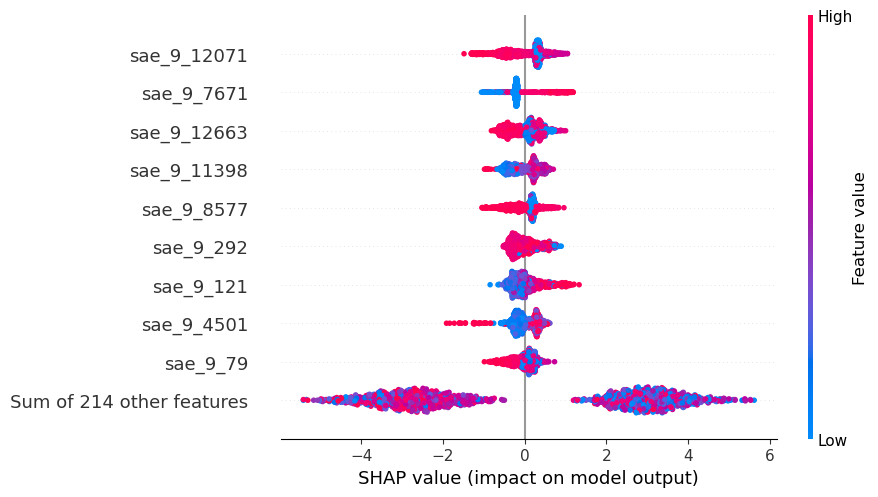

In [24]:
shap.plots.beeswarm(shap_values)


In [26]:
from tools.sae import display_dashboard

sae_conf = sae_9_conf
display_dashboard(sae_conf[1], sae_conf[2], latent_idx=7671)

https://neuronpedia.org/gemma-2-9b-it/9-gemmascope-res-16k/7671?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       local       0.74      0.26      0.39       130
        west       0.38      0.83      0.52        70

    accuracy                           0.46       200
   macro avg       0.56      0.55      0.45       200
weighted avg       0.61      0.46      0.43       200



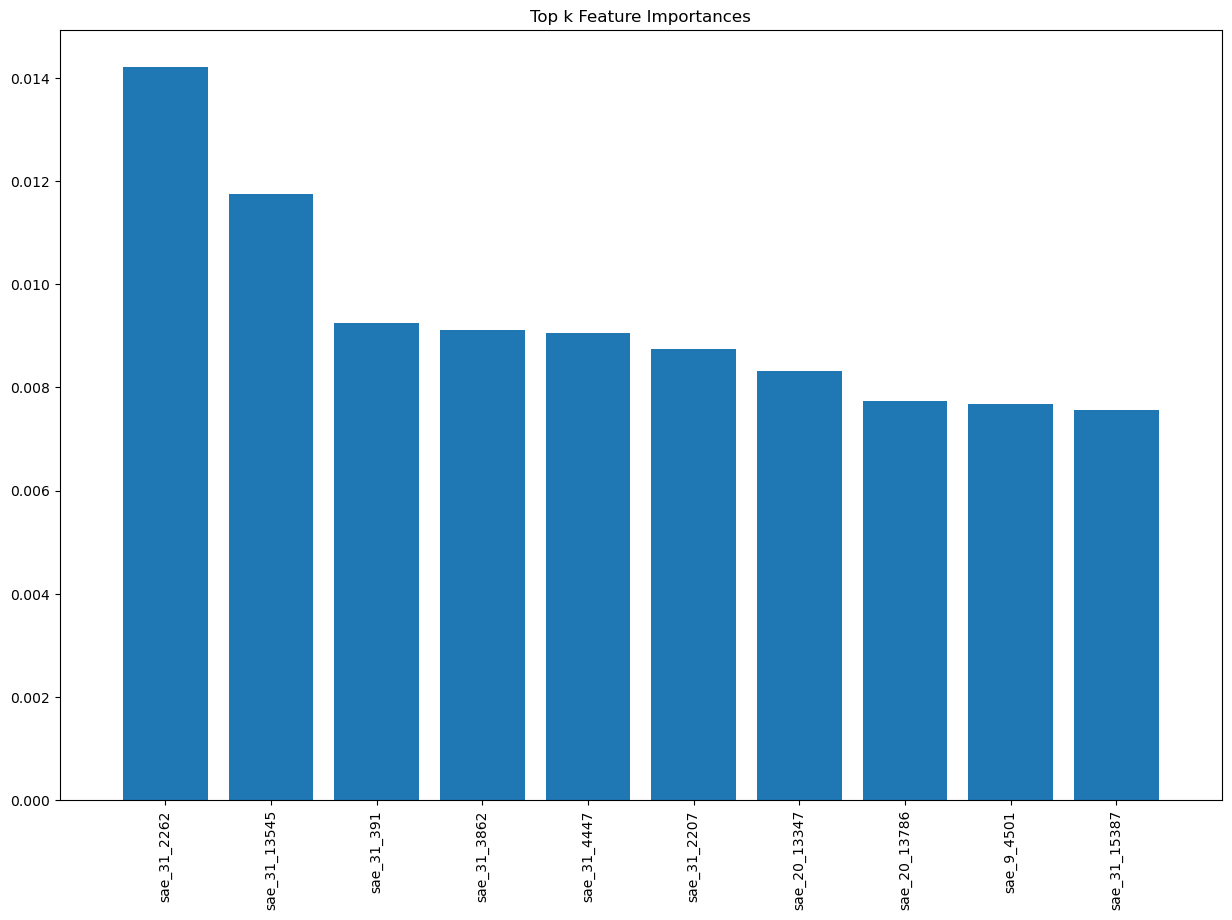

In [163]:
import numpy as np

import matplotlib.pyplot as plt

# Get feature importances
importances = clf.feature_importances_

# Get indices of the features sorted by importance
indices = np.argsort(importances)[::-1]
# Define the number of top features to plot
k = 10

# Select the top k features
top_k_indices = indices[:k]
top_k_importances = importances[top_k_indices]
top_k_features = [X_train.columns[i] for i in top_k_indices]

# Plot the top k feature importances
plt.figure(figsize=(15, 10))
plt.title("Top k Feature Importances")
plt.bar(range(k), top_k_importances, align="center")
plt.xticks(range(k), top_k_features, rotation=90)
plt.xlim([-1, k])
plt.show()

In [24]:
import shap
shap.initjs()  # for interactive plots in Jupyter notebooks

# Create the explainer
explainer = shap.TreeExplainer(clf)

# Get SHAP values
shap_values = explainer.shap_values(X_train)




AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [27]:
len(shap_values)

1268

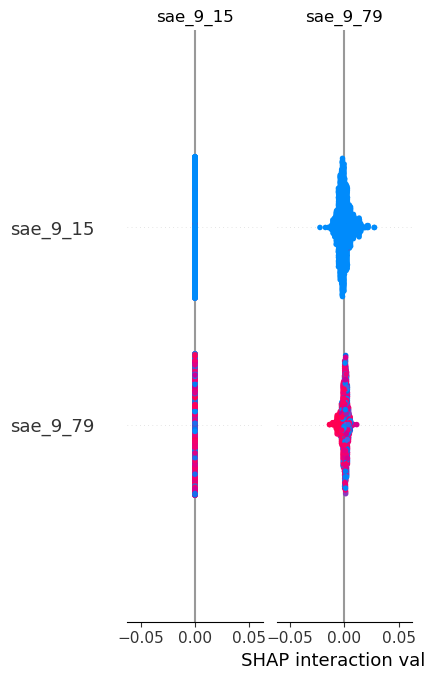

DimensionError: Length of features is not equal to the length of shap_values!

In [25]:
# Global feature importance
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)


# Local explanation for the first sample
shap.force_plot(explainer.expected_value[1],
                shap_values[1][0,:],
                X_train.iloc[0,:])

In [167]:
from tools.sae import display_dashboard

sae_conf = sae_31_conf
display_dashboard(sae_conf[1], sae_conf[2], latent_idx=3862)


https://neuronpedia.org/gemma-2-9b-it/31-gemmascope-res-16k/3862?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [29]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=4)


# Train the classifier
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [30]:
from sklearn.metrics import accuracy_score

# Predict the labels for the test set
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {accuracy:.2f}")

Test Accuracy: 0.43
Train Accuracy: 0.72


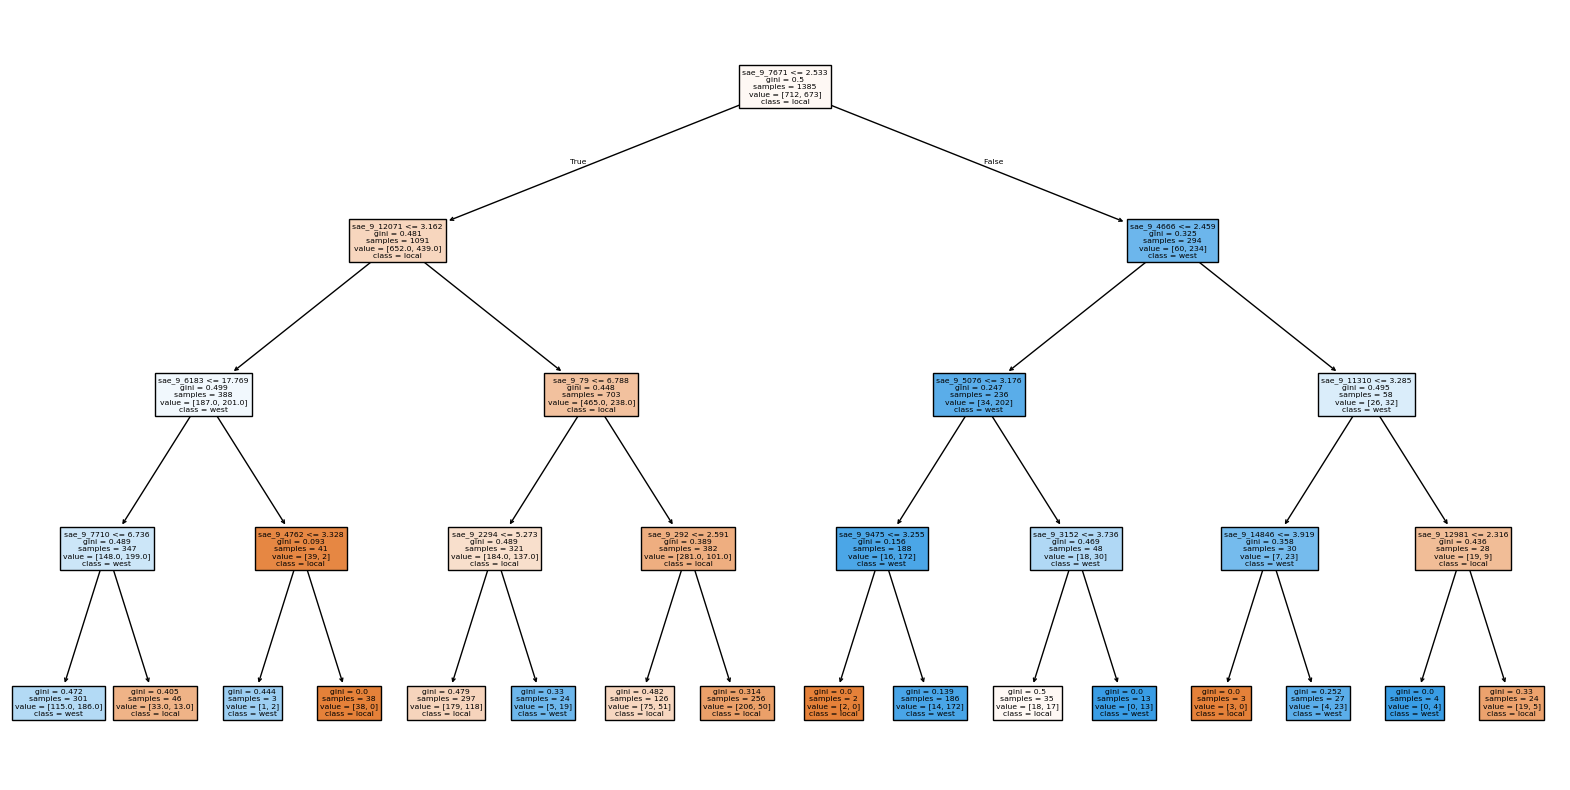

In [31]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=[str(i) for i in features], class_names=clf.classes_, filled=True,)
plt.show()

In [32]:
from tools.sae import display_dashboard

sae_conf = sae_9_conf
display_dashboard(sae_conf[1], sae_conf[2], latent_idx=7671)


https://neuronpedia.org/gemma-2-9b-it/9-gemmascope-res-16k/7671?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


In [137]:
sae_conf

(SAE(
   (activation_fn): ReLU()
   (hook_sae_input): HookPoint()
   (hook_sae_acts_pre): HookPoint()
   (hook_sae_acts_post): HookPoint()
   (hook_sae_output): HookPoint()
   (hook_sae_recons): HookPoint()
   (hook_sae_error): HookPoint()
 ),
 'gemma-scope-9b-it-res-canonical',
 'layer_20/width_16k/canonical')

In [138]:
import requests

url = "https://www.neuronpedia.org/api/feature/gemma-2-9b-it/20-gemmascope-res-16k/154"

headers = {"X-Api-Key": "QUxMIFIPVVlgQkFTRSBBUkUgQkVMT05HIFRIFVT"}

response = requests.get(url, headers=headers)

print(response.json())

{'modelId': 'gemma-2-9b-it', 'layer': '20-gemmascope-res-16k', 'index': '154', 'sourceSetName': 'gemmascope-res-16k', 'creatorId': 'cljj57d3c000076ei38vwnv35', 'createdAt': '2024-09-04T16:11:38.736Z', 'maxActApprox': 27.802, 'hasVector': False, 'vector': [], 'vectorLabel': None, 'vectorDefaultSteerStrength': 10, 'hookName': None, 'topkCosSimIndices': [154, 15397, 4066, 1576, 9361, 9217, 5857, 16164, 14170, 10186, 11020, 9107, 16262, 9271, 7054, 8409, 1744, 12367, 579, 820, 2646, 7478, 15714, 15250, 15984], 'topkCosSimValues': [1, 0.1768, 0.1761, 0.1377, 0.1322, 0.1195, 0.1185, 0.1183, 0.1089, 0.1054, 0.1031, 0.0981, 0.0968, 0.0963, 0.0953, 0.0943, 0.0936, 0.0927, 0.0891, 0.0887, 0.0873, 0.0872, 0.0861, 0.0861, 0.0848], 'neuron_alignment_indices': [417, 46, 3087], 'neuron_alignment_values': [0.075, 0.071, 0.065], 'neuron_alignment_l1': [0.002, 0.002, 0.001], 'correlated_neurons_indices': [3485, 3087, 212], 'correlated_neurons_pearson': [0.046, 0.039, 0.037], 'correlated_neurons_l1': [0.

In [140]:
import json

# Assuming `response` is the variable holding the response from the API
response_json = response.json()

# Dump the response as JSON
with open('response.json', 'w') as f:
    json.dump(response_json, f, indent=4)

In [139]:
response.json().keys()

dict_keys(['modelId', 'layer', 'index', 'sourceSetName', 'creatorId', 'createdAt', 'maxActApprox', 'hasVector', 'vector', 'vectorLabel', 'vectorDefaultSteerStrength', 'hookName', 'topkCosSimIndices', 'topkCosSimValues', 'neuron_alignment_indices', 'neuron_alignment_values', 'neuron_alignment_l1', 'correlated_neurons_indices', 'correlated_neurons_pearson', 'correlated_neurons_l1', 'correlated_features_indices', 'correlated_features_pearson', 'correlated_features_l1', 'neg_str', 'neg_values', 'pos_str', 'pos_values', 'frac_nonzero', 'freq_hist_data_bar_heights', 'freq_hist_data_bar_values', 'logits_hist_data_bar_heights', 'logits_hist_data_bar_values', 'decoder_weights_dist', 'umap_cluster', 'umap_log_feature_sparsity', 'umap_x', 'umap_y', 'model', 'lists', 'creator', 'source', 'sourceSet', 'activations', 'explanations'])